In [1]:
import pandas as pd
from zipfile import ZipFile
from zipfile import is_zipfile
import io
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import glob
import cv2
from keras import models
from keras import layers
import shutil
import os
import glob
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

/home/g404tests/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Definición del problema

A partir de un conjunto de imágenes de tejido mamario se pretende construír una red neuronal que sea capaz de predecir con un porcentaje alto de probabilidad si un tejido dado es susceptible considerarse o no canceroso.


#### Exploración de los datos
Se han dividido las imágenes en la siguiente estructura de directorios:

train/cancer

train/no_cancer

val/cancer

val/no_cancer



A continuación se muestra el número de imágenes de cada directorio

In [2]:
imageTrainCancer = glob.glob( 'train/cancer/*.tif', recursive=True)
imageTrainNoCancer = glob.glob( 'train/no_cancer/*.tif', recursive=True)
imageValCancer = glob.glob( 'val/cancer/*.tif', recursive=True)
imageValNoCancer = glob.glob( 'val/no_cancer/*.tif', recursive=True)
imageTest = glob.glob( 'test/*.tif', recursive=True)

print('Imágenes de train cancer '+str(len(imageTrainCancer)))
print('Imágenes de train no cancer '+str(len(imageTrainNoCancer)))
print('Imágenes de val cancer '+str(len(imageValCancer)))
print('Imágenes de val no cancer '+str(len(imageValNoCancer)))
print('Imágenes de test '+str(len(imageTest)))


Imágenes de train cancer 65776
Imágenes de train no cancer 96791
Imágenes de val cancer 23341
Imágenes de val no cancer 34117
Imágenes de test 57458


Tal y como se puede observar, en los grupos de train y validation, el porcentaje de imágenes cancersosas es del 59%.
Ambos grupos están creados con la misma proporción de casos cancerosos/no cancerosos.

##### Forma de las imágenes

In [3]:
imagenEjemlo=cv2.imread(imageTrainCancer[0])
print(imagenEjemlo.shape)

(96, 96, 3)


Tal y como se aprecia, cada imágen tiene la siguiente forma: (96,96,3)

#### Ejemplos de imágenes con tejido canceroso

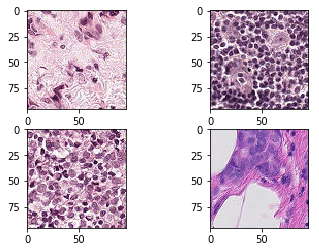

In [4]:
fig, axes = plt.subplots(2,2)
i=0
for i in range(4):    
    imagenCancerosa=imageTrainCancer[i]
    img=mpimg.imread(imagenCancerosa,'r')
    axes[i//2,i%2].imshow(img)
    plt.imshow(img)
    i+=1

#### Ejemplos de imágenes con tejido no canceroso

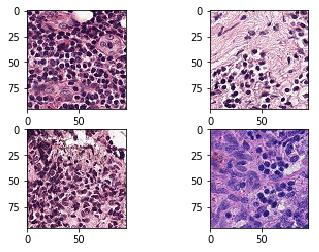

In [5]:
fig, axes = plt.subplots(2,2)
i=0
for i in range(4):    
    imagenCancerosa=imageTrainNoCancer[i]
    img=mpimg.imread(imagenCancerosa,'r')
    axes[i//2,i%2].imshow(img)
    plt.imshow(img)
    i+=1

### Creación y ejecución de modelo de predicción 

In [3]:
#Constantes
IMAGES_TRAIN=162566
IMAGES_VAL=57458
IMAGES_TEST=57458

#### Creación de GridSearchCV personalizado para fit_generator

In [4]:
import random
class EstimadorParametros:
   
  

    def __init__(self,estimator,param_grid,epochs=3):
        self.estimator = estimator
        self.param_grid = param_grid
        self.epochs = epochs

        keys=param_grid.keys()
        modelos=[]
        self.parametrosListado=[]
        parametrosNombres=list(param_grid.keys())
        parametros1=param_grid[parametrosNombres[0]]
        parametros2=param_grid[parametrosNombres[1]]

        for i in parametros1:
            for j in parametros2:             
                parametros=[i,j]
                self.parametrosListado.append(parametros)

        #Mejores parámetros obtenidos
        self.best_params_= []

    #Fit_generator, en el cual se hacen llamadas a fit_generator por cada modelo creado
    def fit_generator(self, train_gen,steps_per_epoch,val_data,val_steps,ep,verb, work):
        lowestLoss=1000
        
        #Se hacen llamadas a fit_generator por cada modelo creado (array modelos)
        #Los mejores parámetros se acabarán guardando en best_params
        for parametros in self.parametrosListado:
            print('fit_geneartor con'+str(parametros))
            modelo=self.estimator(*parametros)
           
            history=modelo.fit_generator(train_gen, steps_per_epoch=steps_per_epoch, 
                        validation_data=val_data,
                        validation_steps=val_steps,
                        epochs=ep, verbose=verb, workers=work)   
            
                        
            
            loss,accuracy = modelo.evaluate_generator(val_gen)
            print('loss {} '.format(loss))
            
           
            if loss<lowestLoss:               
                self.best_params_=parametros
                lowestLoss=loss               
     

#### Funciones para generadores de imágenes (Sin DataUgmentation)

In [4]:
def crearGeneradores(batch_size):
    datagen = ImageDataGenerator(rescale=1.0/255) #Se aplica normalización
    train_gen = datagen.flow_from_directory('train',
                                            target_size=(96,96),
                                            batch_size=batch_size,
                                            class_mode='categorical')

    val_gen = datagen.flow_from_directory('val',
                                            target_size=(96,96),
                                            batch_size=batch_size,
                                            class_mode='categorical')

   
    return train_gen, val_gen

def crearGeneradorTest():
    datagen = ImageDataGenerator(rescale=1.0/255) #Se aplica normalización
    test_gen = datagen.flow_from_directory('val',
                                            target_size=(96,96),
                                            batch_size=1,
                                            class_mode='categorical',
                                            shuffle=False)
    return test_gen

#### Función para generadores de imágenes (Con DataUgmentation)

In [5]:
def crearGeneradoresDA(batch_size):

    
    datagenDA = ImageDataGenerator(rescale=1./255,
                        rotation_range=180, # grados de rotacion aleatoria                       
                        vertical_flip=True,
                        width_shift_range=0.1, # fraccion del total (1) para mover la imagen
                        height_shift_range=0.1, # fraccion del total (1) para mover la imagen
                        shear_range=0.2, # deslizamiento
                        zoom_range=0.1, # rango de zoom
                        horizontal_flip=True, # girar las imagenes horizontalmente (eje vertical)                       
                        brightness_range=[0.1,0.2]  )  
                    

    
    
    train_gen = datagenDA.flow_from_directory('train',
                                            target_size=(96,96),
                                            batch_size=batch_size,
                                            class_mode='categorical')

    val_gen = datagenDA.flow_from_directory('val',
                                            target_size=(96,96),
                                            batch_size=batch_size,
                                            class_mode='categorical')

   
    return train_gen, val_gen

#### Función para visualizar el modelo

In [5]:
def visualizarModelo(history):
  #accuracy
    epochs = np.arange(1,len(history.history['acc'])+1)
    plt.title('Accuracy over training')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.plot(epochs,history.history['acc'],'r',label='training accuracy')
    plt.plot(epochs,history.history['val_acc'],'b',label='validation accuracy')
    plt.legend(loc='best')
    plt.show()
  
    #loss
    epochs = np.arange(1,len(history.history['loss'])+1)
    plt.title('Loss over training')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(epochs,history.history['loss'],'r',label='training loss')
    plt.plot(epochs,history.history['val_loss'],'b',label='validation loss')
    plt.legend(loc='best')
    plt.show()

#### Creación de modelo secuencial  

In [7]:
from keras import models
from keras import layers    
from keras import optimizers

def crearModeloSecuencial(dropout=0.3,optimizerType='Adam'):   
    model = models.Sequential()
    model.add(layers.Conv2D(32,(3,3),input_shape=(96,96,3)))     
    model.add(layers.MaxPooling2D((2,2)))
    
    model.add(layers.Conv2D(32,(3,3),activation='relu', padding='same'))
    model.add(layers.Conv2D(32,(3,3),activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Conv2D(64,(3,3),activation='relu', padding='same'))
    model.add(layers.Conv2D(64,(3,3),activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Conv2D(128,(3,3),activation='relu', padding='same'))
    model.add(layers.Conv2D(128,(3,3),activation='relu', padding='same'))
    
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Conv2D(256,(3,3),activation='relu', padding='same'))
    model.add(layers.Conv2D(256,(3,3),activation='relu', padding='same'))
    
    
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Flatten())
    
    model.add(layers.Dense(64,activation='relu')) 
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(2,activation='sigmoid'))
    
    if optimizerType=='Adam':
        optimizer = optimizers.Adam(lr=0.001)
    elif optimizerType=='SGD':
        optimizer = optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)
    
    
    model.compile(optimizer=optimizer,
               loss='categorical_crossentropy',
               metrics=['accuracy'])       
           
    return model

### Estimador de parámetros

In [11]:
BATCH_SIZE=100
LEARNING_RATE=0.001
DROPOUT=0.3
train_gen,val_gen=crearGeneradores(BATCH_SIZE)
#Optimizers, Dropout
param_grid = {'dropout': [0.2,0.3,0.5],
    'optimizers': ['Adam', 'SGD'],}


grid = EstimadorParametros(crearModeloSecuencial,param_grid)

grid_result = grid.fit_generator(train_gen, IMAGES_TRAIN//BATCH_SIZE, 
                    val_gen,
                    IMAGES_VAL//BATCH_SIZE,
                    2, 1, 4)

print('Mejores parametros '+str(grid.best_params_))

Found 162567 images belonging to 2 classes.
Found 57458 images belonging to 2 classes.
fit_geneartor con[0.2, 'Adam']
Epoch 1/2
1625/1625 [==============================] - 1582s 974ms/step - loss: 0.4259 - acc: 0.8045 - val_loss: 0.3251 - val_acc: 0.8609
Epoch 2/2
1625/1625 [==============================] - 476s 293ms/step - loss: 0.3075 - acc: 0.8727 - val_loss: 0.2604 - val_acc: 0.8954
loss 0.26073131991441467 
fit_geneartor con[0.2, 'SGD']
Epoch 1/2
1625/1625 [==============================] - 473s 291ms/step - loss: 0.6184 - acc: 0.6498 - val_loss: 0.5432 - val_acc: 0.7631
Epoch 2/2
1625/1625 [==============================] - 473s 291ms/step - loss: 0.4617 - acc: 0.7973 - val_loss: 0.4278 - val_acc: 0.8122
loss 0.4277241441663596 
fit_geneartor con[0.3, 'Adam']
Epoch 1/2
1625/1625 [==============================] - 483s 297ms/step - loss: 0.4895 - acc: 0.7550 - val_loss: 0.3521 - val_acc: 0.8479
Epoch 2/2
1625/1625 [==============================] - 475s 293ms/step - loss: 0.344

#### Entrenamiento con los parámetros definitivos
dropout:0.2
optimizer:Adam

In [ ]:
from keras.layers import Input, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
BATCH_SIZE = 100 
DROPOUT = 0.2

train_gen,val_gen=crearGeneradores(BATCH_SIZE)

modeloSecuencial=crearModeloSecuencial(DROPOUT,'Adam')


earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=2, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
#Mejor modelo
mcp_save = ModelCheckpoint('ModeloSecuencial.h5', save_best_only=True, monitor='val_loss', mode='min')
#Modelo guardado en cada epoch, por si se reinicia la máquina por error
mcp_save_tmp = ModelCheckpoint('ModeloSecuencial_tmp.h5', save_best_only=False, monitor='val_loss', mode='min')

history = modeloSecuencial.fit_generator(train_gen, steps_per_epoch=IMAGES_TRAIN//BATCH_SIZE, 
                    validation_data=val_gen,
                    validation_steps=IMAGES_VAL//BATCH_SIZE,
                    callbacks = [reduce, earlystopper, mcp_save, mcp_save_tmp],            
                    epochs=30, verbose=1, workers=4)


Found 162567 images belonging to 2 classes.
Found 57458 images belonging to 2 classes.
Epoch 1/30
1625/1625 [==============================] - 483s 297ms/step - loss: 0.4233 - acc: 0.8078 - val_loss: 0.3545 - val_acc: 0.8448
Epoch 2/30
1625/1625 [==============================] - 484s 298ms/step - loss: 0.3189 - acc: 0.8650 - val_loss: 0.2876 - val_acc: 0.8814
Epoch 3/30
1625/1625 [==============================] - 481s 296ms/step - loss: 0.2721 - acc: 0.8888 - val_loss: 0.2488 - val_acc: 0.9008
Epoch 4/30
1625/1625 [==============================] - 479s 295ms/step - loss: 0.2464 - acc: 0.9019 - val_loss: 0.2237 - val_acc: 0.9138
Epoch 5/30
1625/1625 [==============================] - 482s 297ms/step - loss: 0.2166 - acc: 0.9148 - val_loss: 0.2038 - val_acc: 0.9211
Epoch 7/30
1625/1625 [==============================] - 481s 296ms/step - loss: 0.2042 - acc: 0.9212 - val_loss: 0.1858 - val_acc: 0.9311
Epoch 8/30
1625/1625 [==============================] - 479s 295ms/step - loss: 0.196

#### Segunda iteración

In [9]:
from keras.layers import Input, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
BATCH_SIZE = 100 
DROPOUT = 0.2

train_gen,val_gen=crearGeneradores(BATCH_SIZE)

modeloSecuencial=load_model('ModeloSecuencial_tmp.h5')


earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=2, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
#Mejor modelo
mcp_save = ModelCheckpoint('ModeloSecuencial_2.h5', save_best_only=True, monitor='val_loss', mode='min')
#Modelo guardado en cada epoch, por si se reinicia la máquina por error
mcp_save_tmp = ModelCheckpoint('ModeloSecuencial_2_tmp.h5', save_best_only=False, monitor='val_loss', mode='min')

history = modeloSecuencial.fit_generator(train_gen, steps_per_epoch=IMAGES_TRAIN//BATCH_SIZE, 
                    validation_data=val_gen,
                    validation_steps=IMAGES_VAL//BATCH_SIZE,
                    callbacks = [reduce, earlystopper, mcp_save, mcp_save_tmp],            
                    epochs=10, verbose=1, workers=4)

Found 162567 images belonging to 2 classes.
Found 57458 images belonging to 2 classes.
Epoch 1/10
1625/1625 [==============================] - 1618s 996ms/step - loss: 0.1362 - acc: 0.9510 - val_loss: 0.1476 - val_acc: 0.9460
Epoch 2/10
1625/1625 [==============================] - 461s 284ms/step - loss: 0.1360 - acc: 0.9504 - val_loss: 0.1478 - val_acc: 0.9459

Epoch 00002: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 3/10
1625/1625 [==============================] - 461s 283ms/step - loss: 0.1369 - acc: 0.9496 - val_loss: 0.1476 - val_acc: 0.9461

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
Epoch 4/10
1625/1625 [==============================] - 465s 286ms/step - loss: 0.1363 - acc: 0.9504 - val_loss: 0.1476 - val_acc: 0.9460

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


#### Visualización gráfica de precisión y pérdida

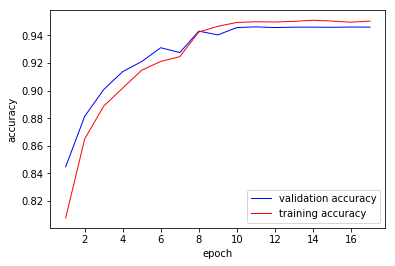

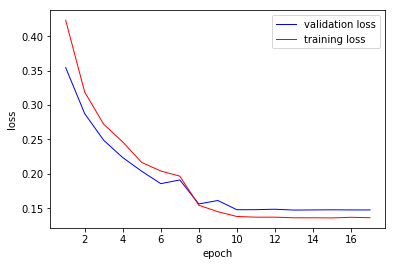

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
fig,axis = plt.subplots(1,1)

validationAcc=[0.8448,0.8814,0.9008,0.9138,0.9211,0.9311, 0.9276,0.9431,0.9404, 0.9457, 0.9462,0.9457, 0.9460, 0.9460,0.9459,0.9461,0.9460] #Datos del eje y para validation accuracy
trainingAcc=[0.8078,0.8650,0.8888,0.9019,0.9148, 0.9212, 0.9246, 0.9425,0.9466,0.9494,0.9499,0.9497,0.9502,0.9510,0.9504,0.9496, 0.9504 ] #Datos del eje y para training accuracy

lista=list(range(1,18)) #Datos para los ejes x
axis.plot(lista,validationAcc,'b-',label='validation accuracy',linewidth=1) 
axis.plot(lista,trainingAcc,'r',label='training accuracy',linewidth=1) 
axis.legend(loc='best') 
axis.set_xlabel('epoch')
axis.set_ylabel('accuracy')
plt.show() 


fig2,axis2 = plt.subplots(1,1)
validationLoss=[0.3545,0.2876 ,0.2488 ,0.2237 ,0.2038 ,0.1858 ,0.1912 ,0.1563 ,0.1613 ,0.1479 ,0.1480 ,0.1486 ,0.1474 ,0.1476 ,0.1478 ,0.1476 ,0.1476 ]
trainingLoss=[0.4233 ,0.3189 ,0.2721 ,0.2464 ,0.2166 ,0.2042 ,0.1967 ,0.1545 ,0.1450 ,0.1381 ,0.1371 ,0.1371 ,0.1362 ,0.1362 ,0.1360 ,0.1369 ,0.1363 ]
axis2.plot(lista,validationLoss,'b-',label='validation loss',linewidth=1) 
axis2.plot(lista,trainingLoss,'r',label='training loss',linewidth=1) 
axis2.legend(loc='best') 
axis2.set_xlabel('epoch')
axis2.set_ylabel('loss')
plt.show()

#### Evaluación del modelo secuencial

In [13]:
modeloSecuencial=load_model('ModeloSecuencial.h5')
test_gen=crearGeneradorTest()
loss,accuracy = modeloSecuencial.evaluate_generator(test_gen)
print('loss {} accuracy {}'.format(loss,accuracy))

Found 57458 images belonging to 2 classes.
loss 0.14771201743074444 accuracy 0.9459083156392495


In [14]:
modeloSecuencial.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 47, 47, 32)        9248      
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 47, 47, 32)        9248      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 23, 23, 64)        18496     
__________

In [15]:
datagen = ImageDataGenerator(rescale=1.0/255)
test_gen=crearGeneradorTest()
predictions = modeloSecuencial.predict_generator(test_gen, steps=IMAGES_VAL, verbose=1)
print(len(predictions))

Found 57458 images belonging to 2 classes.
57458/57458 [==============================] - 617s 11ms/step
57458


In [16]:
predictions.shape

(57458, 2)

In [17]:
test_gen.class_indices

{'cancer': 0, 'no_cancer': 1}

In [18]:
df_preds = pd.DataFrame(predictions, columns=['cancer', 'no_cancer'])
val_archivos = test_gen.filenames
print(len(df_preds))
df_preds['archivos'] = val_archivos
df_preds.head(5)

57458


,cancer,no_cancer,archivos
0,1.000000,0.001760,cancer/00001b2b5609af42ab0ab276dd4cd41c3e7745b...
1,0.999978,0.058957,cancer/0000da768d06b879e5754c43e2298ce48726f72...
2,1.000000,0.001115,cancer/00014e39b5df5f80df56f18a0a049d1cc6de430...
3,1.000000,0.000063,cancer/0001a2bc5d4aa55989f014bfad74a95ac3dfff5...
4,0.999956,0.064087,cancer/0002d959eecbd8d7f6614fdd513154e8e0e8e96...


In [19]:
from sklearn.metrics import roc_auc_score
roc_auc_score(test_gen.classes, df_preds['no_cancer'])

0.9824641989059899

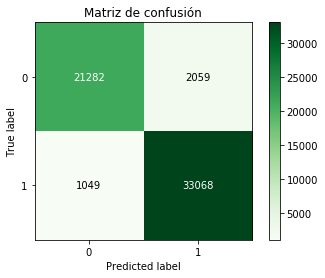

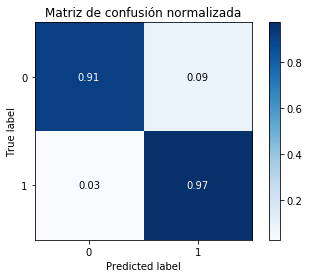

In [20]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
val_labels = test_gen.classes
val_labels.shape
matriz_confusion = confusion_matrix(val_labels, predictions.argmax(axis=1))
#print (matriz_confusion)

skplt.metrics.plot_confusion_matrix(val_labels, predictions.argmax(axis=1), normalize=False, title='Matriz de confusión',cmap=plt.cm.Greens)
skplt.metrics.plot_confusion_matrix(val_labels, predictions.argmax(axis=1), normalize=True, title='Matriz de confusión normalizada')


In [21]:
from sklearn.metrics import classification_report

y_pred_binary = predictions.argmax(axis=1)
report = classification_report(test_gen.classes, y_pred_binary, target_names=['cancer','no_cancer'])
print("Obtención de métricas:\r\n")
print(report)

Obtención de métricas:

             precision    recall  f1-score   support

     cancer       0.95      0.91      0.93     23341
  no_cancer       0.94      0.97      0.96     34117

avg / total       0.95      0.95      0.95     57458



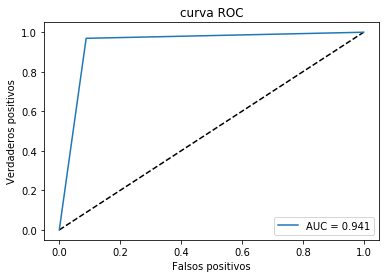

In [22]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
false_positive_rate, true_positive_rate, threshold = roc_curve(test_gen.classes, predictions.argmax(axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('Falsos positivos')
plt.ylabel('Verdaderos positivos')
plt.title('curva ROC')
plt.legend(loc='best')
plt.show()

In [23]:
np.save('predictions1.npy', predictions)    
predictions = np.load('predictions1.npy')
print(len(predictions))


57458


### Modelo secuencial con ImageAugmentation
Se comprueba si el uso de ImageAugmentation mejora los resultados, mediante el entrenamiento de una iteración

In [25]:
from keras.layers import Input, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
BATCH_SIZE = 100 
DROPOUT = 0.2

train_gen,val_gen=crearGeneradoresDA(BATCH_SIZE)

modelo1=crearModeloSecuencial(DROPOUT,'Adam')

history = modelo1.fit_generator(train_gen, steps_per_epoch=IMAGES_TRAIN//BATCH_SIZE, 
                    validation_data=val_gen,
                    validation_steps=IMAGES_VAL//BATCH_SIZE,
                    epochs=1, verbose=1, workers=4)

Found 162567 images belonging to 2 classes.
Found 57458 images belonging to 2 classes.
Epoch 1/1
1625/1625 [==============================] - 694s 427ms/step - loss: 0.6733 - acc: 0.5954 - val_loss: 0.6762 - val_acc: 0.5919


No se aprecian ventajas en usar ImageAugmentation en este modelo.

#### Se prueba ImageAugmentation quitando algunas otras parametrizaciones

In [13]:
def crearGeneradoresDA2(batch_size):

    
    datagenDA = ImageDataGenerator(rescale=1./255,
                        rotation_range=180, # grados de rotacion aleatoria                       
                        vertical_flip=True,
                        #horizontal_flip=True, # girar las imagenes horizontalmente (eje vertical)
                        brightness_range=[0.1,0.2])  
                    

    
    
    train_gen = datagenDA.flow_from_directory('train',
                                            target_size=(96,96),
                                            batch_size=batch_size,
                                            class_mode='categorical')

    val_gen = datagenDA.flow_from_directory('val',
                                            target_size=(96,96),
                                            batch_size=batch_size,
                                            class_mode='categorical')

   
    return train_gen, val_gen

In [14]:
from keras.layers import Input, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
BATCH_SIZE = 100 
DROPOUT = 0.2

train_gen,val_gen=crearGeneradoresDA2(BATCH_SIZE)

modeloDA=crearModeloSecuencial(DROPOUT,'Adam')

history = modeloDA.fit_generator(train_gen, steps_per_epoch=IMAGES_TRAIN//BATCH_SIZE, 
                    validation_data=val_gen,
                    validation_steps=IMAGES_VAL//BATCH_SIZE,
                    epochs=1, verbose=1, workers=4)

Found 162567 images belonging to 2 classes.
Found 57458 images belonging to 2 classes.
Epoch 1/1
1625/1625 [==============================] - 1293s 796ms/step - loss: 0.4705 - acc: 0.7815 - val_loss: 0.4134 - val_acc: 0.8117


Los resultados siguen siendo peores que sin ImageAugmentation, igualmente.

In [17]:
def crearGeneradoresDA3(batch_size):

    
    datagenDA = ImageDataGenerator(rescale=1./255,
                        rotation_range=180, # grados de rotacion aleatoria                       
                        #vertical_flip=True,
                        #horizontal_flip=True, # girar las imagenes horizontalmente (eje vertical)
                        )  
                    

    
    
    train_gen = datagenDA.flow_from_directory('train',
                                            target_size=(96,96),
                                            batch_size=batch_size,
                                            class_mode='categorical')

    val_gen = datagenDA.flow_from_directory('val',
                                            target_size=(96,96),
                                            batch_size=batch_size,
                                            class_mode='categorical')

   
    return train_gen, val_gen

In [18]:
from keras.layers import Input, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
BATCH_SIZE = 100 
DROPOUT = 0.2

train_gen,val_gen=crearGeneradoresDA3(BATCH_SIZE)

modeloDA=crearModeloSecuencial(DROPOUT,'Adam')

history = modeloDA.fit_generator(train_gen, steps_per_epoch=IMAGES_TRAIN//BATCH_SIZE, 
                    validation_data=val_gen,
                    validation_steps=IMAGES_VAL//BATCH_SIZE,
                    epochs=1, verbose=1, workers=4)

Found 162567 images belonging to 2 classes.
Found 57458 images belonging to 2 classes.
Epoch 1/1
1625/1625 [==============================] - 654s 402ms/step - loss: 0.4922 - acc: 0.7565 - val_loss: 0.3869 - val_acc: 0.8274


Los resultados siguen siendo peores que sin ImageAugmentation, igualmente. (Parece que cuantas menos parametrizaciones, mejor...)